# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print("CUDA is available!  Training on GPU ...")

CUDA is not available.  Training on CPU ...


In [3]:
import PIL

print(PIL.__version__)

10.3.0


In [6]:
# from google.colab import drive
# drive.mount("/content/gdrive/")

In [ ]:
# !unzip -q ./journey-springfield.zip

In [4]:
!ls train

simpsons_dataset


In [5]:
# !nvidia-smi
# torch.cuda.is_available()
torch.mps.is_available()

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [155]:
import pickle
import numpy as np
from skimage import io

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ["train", "val", "test"]
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
# DEVICE = torch.device("cuda")
DEVICE = torch.device("mps")  # This is for Apple Silicon
DEVICE

device(type='mps')

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [742]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open("label_encoder.pkl", "wb") as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index: int):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        dataset_transforms = [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
        if self.mode == "train":  # Adding augmentation to the data
            dataset_transforms.append(transforms.RandomHorizontalFlip())
            dataset_transforms.append(transforms.RandomRotation(15))
            dataset_transforms.append(transforms.RandomRotation(30))
            # dataset_transforms.append( # This one didn't work well
            #     transforms.ColorJitter(
            #         brightness=0.25,
            #         contrast=0.25,
            #         saturation=0.25,
            #     )
            # )
        transform = transforms.Compose(dataset_transforms)

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype="float32")
        x = transform(x)
        if self.mode == "test":
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
# определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path("./train/")
TEST_DIR = Path("./testset")

In [11]:
train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(
    train_val_files, test_size=0.25, stratify=train_val_labels
)

In [743]:
val_dataset = SimpsonsDataset(val_files, mode="val")

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

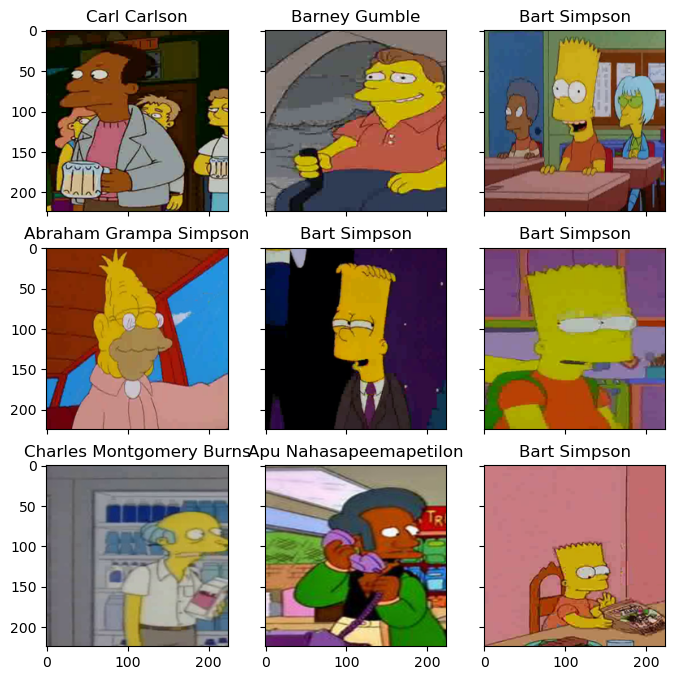

In [744]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(
        map(
            lambda x: x.capitalize(),
            val_dataset.label_encoder.inverse_transform([label])[0].split("_"),
        )
    )
    imshow(im_val.data, title=img_label, plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [751]:
# Очень простая (уже не очень) сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.bn_1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        # self.bn_2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.25),
        )
        self.bn_3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25),
        )
        # self.bn_4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25),
        )
        # self.bn_5 = nn.BatchNorm2d(96)
        conv_out = 96 * 5 * 5
        self.linear_1 = nn.Linear(conv_out, conv_out)
        self.lin_bn_1 = nn.BatchNorm1d(conv_out)

        self.dropout = nn.Dropout(0.3)
        self.linear_2 = nn.Linear(conv_out, n_classes * 4)
        self.lin_bn_2 = nn.BatchNorm1d(n_classes * 4)
        self.linear_3 = nn.Linear(n_classes * 4, n_classes * 4)
        self.linear_4 = nn.Linear(n_classes * 4, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn_1(x)
        x = self.conv2(x)
        # x = self.bn_2(x)
        x = self.conv3(x)
        x = self.bn_3(x)
        x = self.conv4(x)
        # x = self.bn_4(x)
        x = self.conv5(x)
        # x = self.bn_5(x)

        x = x.view(x.size(0), -1)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.lin_bn_1(x)
        x = self.dropout(x)

        x = self.linear_2(x)
        x = F.relu(x)
        x = self.lin_bn_2(x)
        x = F.relu(x)
        x = self.linear_3(x)
        x = F.relu(x)
        logits = self.linear_4(x)

        return logits

In [557]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    if scheduler:
        scheduler.step()

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [550]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.float() / processed_size

    return val_loss, val_acc

In [822]:
def train(
    train_files,
    val_files,
    model: nn.Module,
    num_epochs: int,
    batch_size: int,
    device: torch.device = DEVICE,
) -> list[tuple[float, float, float, float]]:
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d}\
        train_loss: {t_loss:0.4f} train_acc: {t_acc:0.4f} val_loss: {v_loss:0.4f} val_acc: {v_acc:0.4f}"

    with tqdm(desc="epoch", total=num_epochs, leave=True) as pbar_outer:
        optimizer = torch.optim.Adam(model.parameters(), lr=1.2e-3, weight_decay=2e-4)
        # optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.90)
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75)
        criterion = nn.CrossEntropyLoss().to(device)

        for epoch in range(num_epochs):
            train_loss, train_acc = fit_epoch(
                model,
                train_loader,
                criterion,
                optimizer,
                scheduler,
            )
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(
                log_template.format(
                    ep=epoch + 1,
                    t_loss=train_loss,
                    v_loss=val_loss,
                    t_acc=train_acc,
                    v_acc=val_acc,
                )
            )

    return history

In [526]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [752]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
  )
  (con

In [748]:
n_classes

42

Запустим обучение сети.

In [753]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode="val")

train_dataset = SimpsonsDataset(train_files, mode="train")

In [754]:
history = train(
    train_dataset,
    val_dataset,
    model=simple_cnn,
    num_epochs=16,
    batch_size=64,
)

epoch:   0%|          | 0/16 [00:00<?, ?it/s]

loss 2.542960225294271

Epoch 001        train_loss: 2.5430 train_acc: 0.2943 val_loss: 2.0163 val_acc: 0.4392
loss 1.810099256950637

Epoch 002        train_loss: 1.8101 train_acc: 0.4874 val_loss: 1.5517 val_acc: 0.5665
loss 1.353586914459758

Epoch 003        train_loss: 1.3536 train_acc: 0.6111 val_loss: 1.1522 val_acc: 0.6710
loss 1.0840800436213256

Epoch 004        train_loss: 1.0841 train_acc: 0.6906 val_loss: 1.0413 val_acc: 0.7056
loss 0.8779856679553294

Epoch 005        train_loss: 0.8780 train_acc: 0.7465 val_loss: 0.9456 val_acc: 0.7396
loss 0.780210711443999

Epoch 006        train_loss: 0.7802 train_acc: 0.7750 val_loss: 0.8494 val_acc: 0.7545
loss 0.6683305580112249

Epoch 007        train_loss: 0.6683 train_acc: 0.8062 val_loss: 0.7284 val_acc: 0.8028
loss 0.5940710879775458

Epoch 008        train_loss: 0.5941 train_acc: 0.8254 val_loss: 0.6490 val_acc: 0.8250
loss 0.5075402594621079

Epoch 009        train_loss: 0.5075 train_acc: 0.8496 val_loss: 0.6654 val_acc: 0.8

In [756]:
history

[(2.542960225294271,
  0.2943499585960889,
  2.0162870906717596,
  tensor(0.4392, device='mps:0')),
 (1.810099256950637,
  0.48741958086502324,
  1.5517120609130393,
  tensor(0.5665, device='mps:0')),
 (1.353586914459758,
  0.6111217274985667,
  1.1522112802826907,
  tensor(0.6710, device='mps:0')),
 (1.0840800436213256,
  0.690553538441939,
  1.0412681288604386,
  tensor(0.7056, device='mps:0')),
 (0.8779856679553294,
  0.7465443658831773,
  0.945601106646592,
  tensor(0.7396, device='mps:0')),
 (0.780210711443999,
  0.7749538187145678,
  0.8493605168848762,
  tensor(0.7545, device='mps:0')),
 (0.6683305580112249,
  0.8061659978342569,
  0.7284492924325467,
  tensor(0.8028, device='mps:0')),
 (0.5940710879775458,
  0.8254028919039429,
  0.6490229276195026,
  tensor(0.8250, device='mps:0')),
 (0.5075402594621079,
  0.8496082553028855,
  0.6654151548717967,
  tensor(0.8219, device='mps:0')),
 (0.46837715663054286,
  0.8610739537550163,
  0.6213586056191456,
  tensor(0.8338, device='mps:

Построим кривые обучения

In [ ]:
# EXPERIMENTS LOG: trials result with their descriptions

# В порыве лингвистического безумия я начал писать всё по-английски,
# а остановиться уже не смог. Не судите, люди, Христа ради. По одной земле ходим.

# fmt: off

loss, acc, val_loss, val_acc = zip(*history)
# Epoch 003     train_loss: 0.5097 train_acc 0.8502 val_loss 1.0408 val_acc 0.7423
# - default, 5 epochs, F1: 0.6

# Epoch 008     train_loss: 0.2653 train_acc 0.9164 val_loss 0.9951 val_acc 0.7961
#  - add 2 linear layers, set optim to AdamW, 8 epochs, F1: 0.7

# Epoch 005     train_loss: 0.7174 train_acc 0.7935 val_loss 1.0100 val_acc 0.7333
#  - add conv batch norms, 5 epochs, F1: 0.6

# Epoch 005     train_loss: 0.5274 train_acc 0.8475 val_loss 0.9099 val_acc 0.7793
#  - leave 1 conv batch norm, add linear batch norm, 5 epochs, F1: 0.8

# Epoch 005     train_loss: 0.1714 train_acc 0.9470 val_loss 1.0335 val_acc 0.7977
#  - add relu b/w linear layers, 5 epochs, strong overfit, F1: 0.7

# Epoch 005     train_loss: 0.5263 train_acc 0.8416 val_loss 1.1111 val_acc 0.7474
#  - remove relu, fiddle conv batch norms, 5 epochs, overfit holds, F1: 0.65

# Epoch 005     train_loss: 0.4763 train_acc 0.8627 val_loss 1.0083 val_acc 0.7688
#  - leave 1 and 3 conv batch norms, add linear layer, 5 epochs, less overfit, F1: 0.7

# Epoch 005     train_loss: 0.4670 train_acc: 0.8656 val_loss: 0.8255 val_acc: 0.7866
#  - leave only 3rd conv batch norm, add ReLU to all linear layers, 5 epochs, F1: 0.75

# Epoch 005     train_loss: 0.2450 train_acc: 0.9332 val_loss: 1.0753 val_acc: 0.7860
# - lower batch from 64 to 32, 5 epochs - extreme overfit, F1: 0.75

# Epoch 008     train_loss: 0.2576 train_acc: 0.9273 val_loss: 0.9951 val_acc: 0.7904
# - back to batch of 64, add epochs, 8 epochs (6th best), mild overfit, F1: 0.75

# Epoch 007     train_loss: 0.2450 train_acc: 0.9290 val_loss: 0.8263 val_acc: 0.8038
# - add batch norm after the 2nd linear layer, 7 epochs, F1: 0.0 ???

# Epoch 007     train_loss: 0.2750 train_acc: 0.9185 val_loss: 0.8752 val_acc: 0.7956
# - add dropout(p=0.3) after before linear layer 1, comment out unused batch norms from __init__, 7 epochs (5th best) F1: 0.75

# Epoch 005     train_loss: 0.5101 train_acc: 0.8526 val_loss: 0.8047 val_acc: 0.7868
# - remove batch norm after linear layer, limit num epochs to 5, learning more stable, underfit, F1: 0.75

# Epoch 007     train_loss: 0.2891 train_acc: 0.9151 val_loss: 0.8192 val_acc: 0.8007
# - try standard Adam again, add num epochs to 7 for the underfit of the prev trial, F1: 0.8

# Epoch 008     train_loss: 0.0310 train_acc: 0.9940 val_loss: 1.1073 val_acc: 0.8101
# - add ExponentialLR(gamma=0.75) to Adam, num epochs to 8, overfit: probably gamma's too high, F1: 0.8

# Epoch 006     train_loss: 0.2992 train_acc: 0.9133 val_loss: 0.8244 val_acc: 0.8051
# - try StepLR scheduler instead, step=2, same gamma, num epochs 8 (6th best), F1: 0.7

# Epoch 007     train_loss: 0.2709 train_acc: 0.9206 val_loss: 0.8581 val_acc: 0.7982
# - set scheduler gamma to 0.85, optim to AdamW with initial lr=1.5e-3, F1: 0.75

# Epoch 008     train_loss: 0.5056 train_acc: 0.8552 val_loss: 2.1076 val_acc: 0.6605
# - add RandomHorizontalFlip, RandomRotation, ColorJitter transforms to train dataset,
# back to Adam(lr=1.5e-3), scheduler gamma=0.9, validation results are aweful, net barely learns, F1: 0.5

# Epoch 006     train_loss: 0.1937 train_acc: 0.9442 val_loss: 0.7126 val_acc: 0.8445
# - leave only RandomHorizontalFlip transform, best results so far on 6th epoch of 8, then worse, F1: 0.75

# Epoch 006     train_loss: 0.3689 train_acc: 0.9066 val_loss: 0.9184 val_acc: 0.8024
# - limit to 6 epochs, remove scheduler: unimpressive, loss goes up. F1: 0.75

# Epoch 006     train_loss: 0.0217 train_acc: 0.9934 val_loss: 1.1565 val_acc: 0.8454
# - lower learning rate to the standard 1e-03, obvious overfitting

# Epoch 006     train_loss: 0.4808 train_acc: 0.8638 val_loss: 0.7410 val_acc: 0.8011
# - add scheduler back to lower lr iteratively, initial lr back to 1e-3. Not bad: slow, but stable. F1: 0.8

# Epoch 008     train_loss: 0.0686 train_acc: 0.9802 val_loss: 0.7329 val_acc: 0.8487
# - increase num epochs to 10, initial lr=1.2e-3. Best result on 7th epoch, then worse. Good overall. F1: 0.8

# Epoch 010     train_loss: 0.1147 train_acc: 0.9671 val_loss: 0.5812 val_acc: 0.8775 <========== BEST ==========|
# - try adding RandomRotation back, initial lr=1e-3, 10 epochs. Best result so far.
# Using this one as the baseline from now on. F1: 0.9

# Epoch 010     train_loss: 0.4228 train_acc: 0.8745 val_loss: 0.6555 val_acc: 0.8286
# - try AdamW again, lowering the scheduler gamma to 0.85. Smoother convergence. F1: 0.9

# Epoch 015     train_loss: 0.2963 train_acc: 0.9115 val_loss: 0.6560 val_acc: 0.8416
# - add a dropout to conv5 layer, num epochs 15, scheduler gamma 0.9, F1: 0.55

# Epoch 016     train_loss: 0.0555 train_acc: 0.9824 val_loss: 0.6844 val_acc: 0.8760
# - try moving the dropout to conv4 – F1: 0.8

# Epoch 010     train_loss: 0.5267 train_acc: 0.8487 val_loss: 0.7257 val_acc: 0.8089
# - Adam again

# Epoch 016     train_loss: 0.2094 train_acc: 0.9389 val_loss: 0.8370 val_acc: 0.8166
# - alter dropouts: on conv3 and conv4 - F1: 0.7

# Epoch 016     train_loss: 0.3026 train_acc: 0.9146 val_loss: 0.6356 val_acc: 0.8472
# - alter dropouts: on conv4 and conv5 - F1: 0.85

# Epoch 016     train_loss: 0.1855 train_acc: 0.9436 val_loss: 0.5896 val_acc: 0.8720
# - add ReLU and batch norm to the last dense layer, F1: 0.95

# Epoch 016     train_loss: 0.2233 train_acc: 0.9339 val_loss: 0.5999 val_acc: 0.8638
# = add RandomRotation(15) along with (30), F1: 0.9

# Epoch 016     train_loss: 0.2233 train_acc: 0.9339 val_loss: 0.5999 val_acc: 0.8638
# add weight_decay=2e-4 to Adam, F1: 0.95

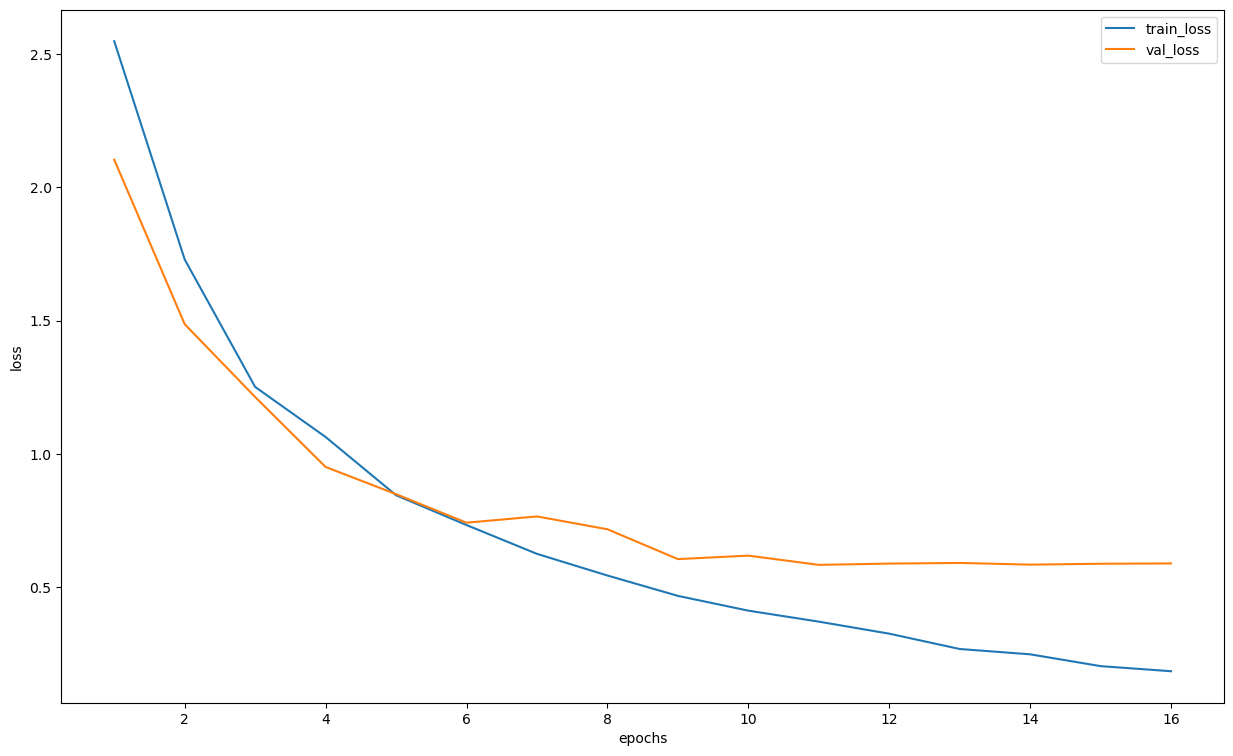

In [757]:
plt.figure(figsize=(15, 9))
plt.plot(range(1, len(val_loss) + 1), loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [758]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [864]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [865]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [866]:
label_encoder = pickle.load(open("label_encoder.pkl", "rb"))

In [867]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [868]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_labels, y_pred, average="micro")

print("F1-оценка:", f1)

F1-оценка: 0.95


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

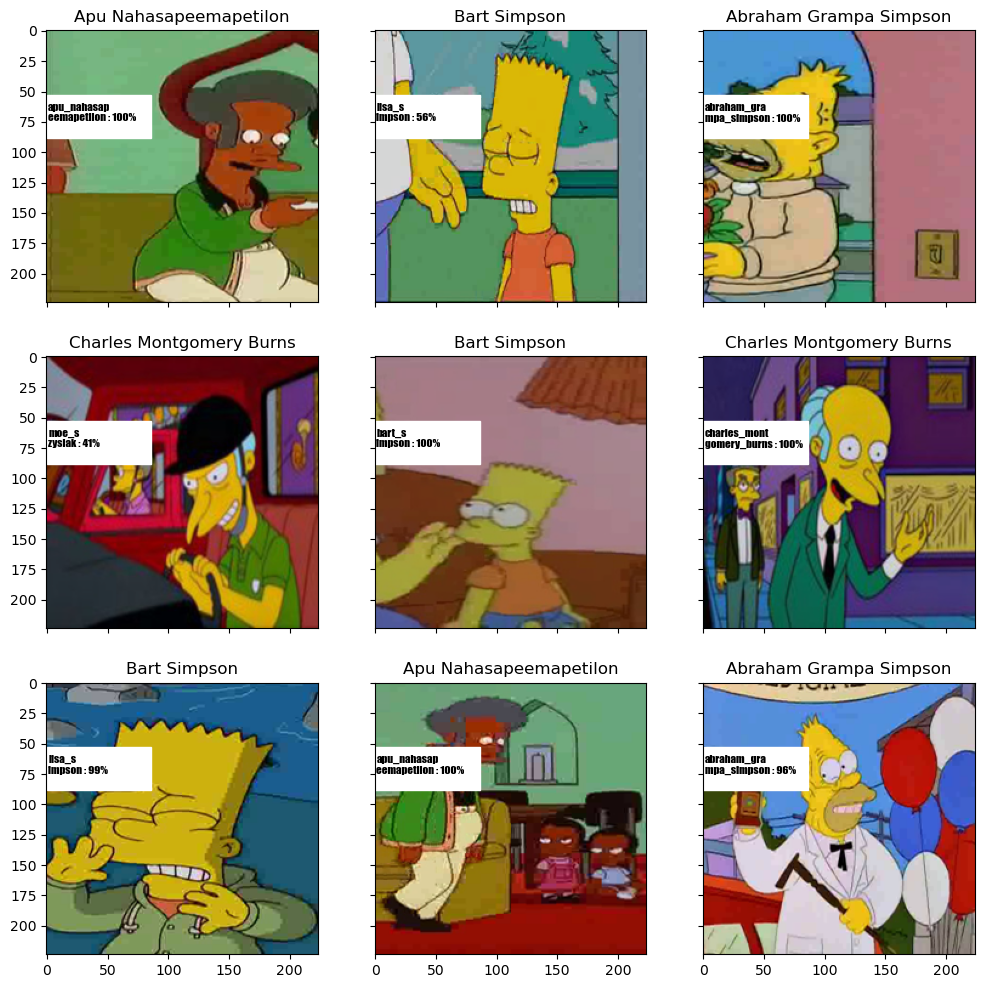

In [737]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(
        map(
            lambda x: x.capitalize(),
            val_dataset.label_encoder.inverse_transform([label])[0].split("_"),
        )
    )

    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color="white"))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = (
        predicted_label[: len(predicted_label) // 2]
        + "\n"
        + predicted_label[len(predicted_label) // 2 :]
    )
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

    fig_x.text(
        1,
        59,
        predicted_text,
        horizontalalignment="left",
        fontproperties=font,
        verticalalignment="top",
        fontsize=8,
        color="black",
        fontweight="bold",
    )

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [738]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [512]:
! ls

[seminar]conv_net_optimization.ipynb sample_submission.csv
[seminar]pytorch_bn_dropout.ipynb    simple_cnn_baseline.csv
[seminar]transfer_learning.ipynb     simpsons_baseline.ipynb
characters_illustration.png          testset
journey-springfield.zip              train
label_encoder.pkl


In [739]:
import pandas as pd

my_submit = pd.read_csv("./sample_submission.csv")
my_submit = pd.DataFrame({"Id": test_filenames, "Expected": preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [740]:
my_submit.to_csv("simple_cnn_baseline.csv", index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочных улучшений для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
